In [1]:
# Set up 
from pprint import pprint

The steps for this analysis are as follows. First, using Neo4j browser, we identified all nodes linking PFNA, the genes of interest, and the outcome using the following query. Note: to get this to run, you have to have an Neo4j instance of comptoxai.

In [2]:
import comptox_ai
from comptox_ai.db.graph_db import GraphDB
db = GraphDB(username="cytoscape", password="12345", hostname="localhost:7687")

# Get all of the nodes, dont return relationships
# nodes = db.run_cypher("MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN ['PSENEN', 'SGK1', 'APOA1', 'GPNMB', 'TGIF2LX', 'ATG3', 'GDF11', 'MSTN', 'IL27', 'FGF8', 'TMEM87B', 'RNF114', 'COLGALT1'] CALL apoc.path.spanningTree(d, {relationshipFilter: '<GENEASSOCIATESWITHDISEASE|GENEINTERACTSWITHGENE', minLevel: 1, maxLevel: 5, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n UNION MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN ['PSENEN', 'SGK1', 'APOA1', 'GPNMB', 'TGIF2LX', 'ATG3', 'GDF11', 'MSTN', 'IL271', 'FGF8', 'TMEM87B', 'RNF114', 'COLGALT1'] CALL apoc.path.spanningTree(c, {relationshipFilter: 'CHEMICALINCREASESEXPRESSION>|CHEMICALDECREASESEXPRESSION>|GENEINTERACTSWITHGENE>', minLevel: 1, maxLevel: 7, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n") 

# Testing another option with including all 35 proteins that were associated with both PFAS and DKD:
nodes = db.run_cypher("MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN ['PSENEN', 'SGK1', 'APOA1', 'GPNMB', 'TGIF2LX', 'ATG3', 'GDF11', 'MSTN', 'IL27', 'FGF8', 'TMEM87B', 'RNF114', 'COLGALT1', 'HSPA1A', 'AKR7A3', 'HSPA1B', 'CLEC4G', 'CHRNA5', 'EDEM2', 'ANP32C', 'FSCN1', 'HEY1', 'DHRS3', 'WASL', 'CLU', 'ADGRG5', 'RSPO2', 'KRT18', 'SNRPF', 'CCN1', 'KLK15', 'SPRED1', 'ISM1', 'GPNMB', 'GALNT16', 'RIPPLY1', 'THOC1'] CALL apoc.path.spanningTree(d, {relationshipFilter: '<GENEASSOCIATESWITHDISEASE|GENEINTERACTSWITHGENE', minLevel: 1, maxLevel: 5, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n UNION MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN ['PSENEN', 'SGK1', 'APOA1', 'GPNMB', 'TGIF2LX', 'ATG3', 'GDF11', 'MSTN', 'IL271', 'FGF8', 'TMEM87B', 'RNF114', 'COLGALT1'] CALL apoc.path.spanningTree(c, {relationshipFilter: 'CHEMICALINCREASESEXPRESSION>|CHEMICALDECREASESEXPRESSION>|GENEINTERACTSWITHGENE>', minLevel: 1, maxLevel: 7, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n") 

Clean the output to get the information on each node individually

In [3]:
# Unlist everything and get a list of separate dictionaries
flattened_list = [inner_dict for outer_dict in nodes for inner_dict in outer_dict['n']]

# Remove duplicates by converting to a set and back to a list
unique_list = list({tuple(item.items()) for item in flattened_list})

# Convert the list of tuples back to dictionaries
unique_list = [dict(item) for item in unique_list]

print(len(unique_list))
# Look at first few elements of list
# pprint(unique_list[0:2])

75


In [4]:
# Extract geneSymbol
# Create a set to store unique geneSymbol values
unique_gene_symbols = set()

# Iterate through the list and collect unique geneSymbol values
for dictionary in flattened_list:
    if 'geneSymbol' in dictionary:
        unique_gene_symbols.add(dictionary['geneSymbol'])

# Convert the set back to a list if needed
unique_gene_symbols_list = list(unique_gene_symbols)

# Now, 'unique_gene_symbols_list' contains all unique geneSymbol values
len(unique_gene_symbols_list)


73

Once we have the nodes, now we can identify all of the relationships between the nodes

In [5]:
# Create cypher query
# Start and end strings
start_string = "MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (node1:Gene) WHERE node1.geneSymbol IN "

end_string = "WITH collect(id(node1))+collect(c)+collect(d) as nodes CALL apoc.algo.cover(nodes) YIELD rel RETURN  startNode(rel), rel, endNode(rel);"

# Combine the start and end strings with the unique_gene_symbols_list
query_string = start_string + "[" + ", ".join(["'" + symbol + "'" for symbol in unique_gene_symbols_list]) + "]" + end_string

#print(query_string)

In [6]:
# Run Cypher Query
data = db.run_cypher(query_string)

In [7]:
print(len(data))
print(type(data))
print(type(data[1]))
#pprint(data[9])
 
# Find elements with 'CHEMICALINCREASESEXPRESSION' in the 'rel' part
filtered_elements = [element for element in data if any('CHEMICALINCREASESEXPRESSION' in item for item in element['rel'])]
# Print the filtered elements
#for idx, element in enumerate(filtered_elements):
#    print(f"Element {idx + 1}:")
#    print(element)

210
<class 'list'>
<class 'dict'>


# Create Graph

In [8]:
# Create network diagram
import networkx as nx
import matplotlib.pyplot as plt
# Create a new graph
G = nx.DiGraph()

# List mediator proteins
#TODAY_genes_minimal = ['PSENEN', 'SGK1', 'APOA1', 'GPNMB', 'TGIF2LX', 'ATG3', 'GDF11', 'MSTN', 'IL271', 'FGF8', 'TMEM87B', 'RNF114', 'COLGALT1']

TODAY_genes = ['PSENEN', 'SGK1', 'APOA1', 'GPNMB', 'TGIF2LX', 'ATG3', 'GDF11', 'MSTN', 'IL27', 'FGF8', 'TMEM87B', 'RNF114', 'COLGALT1', 'HSPA1A', 'AKR7A3', 'HSPA1B', 'CLEC4G', 'CHRNA5', 'EDEM2', 'ANP32C', 'FSCN1', 'HEY1', 'DHRS3', 'WASL', 'CLU', 'ADGRG5', 'RSPO2', 'KRT18', 'SNRPF', 'CCN1', 'KLK15', 'SPRED1', 'ISM1', 'GPNMB', 'GALNT16', 'RIPPLY1', 'THOC1']

# Function to compute the combined 'type' attribute
def compute_type(node):
    if node.get('commonName') == 'PFNA':
        return 'PFAS'
    elif node.get('typeOfGene') == 'protein-coding':
        if node.get('geneSymbol') in TODAY_genes:
            return 'mediating-protein'
        else:
            return 'non-identified protein'
    else:
        return 'Disease'
    
# Add nodes and edges with combined 'type' attribute
for entry in data:
    start_node = entry['startNode(rel)']
    end_node = entry['endNode(rel)']
    rel_type = entry['rel'][1]  # Relationship type is the second item in the tuple
    
    # Set combined 'type' attribute
    start_node['type'] = compute_type(start_node)
    end_node['type'] = compute_type(end_node)

    # Node identifiers
    start_node_id = start_node.get('geneSymbol')  or start_node.get('commonName')
    end_node_id = end_node.get('geneSymbol') or end_node.get('xrefUmlsCUI') 

    # Add nodes with combined 'type' attribute
    G.add_node(start_node_id, **start_node)
    G.add_node(end_node_id, **end_node)

    # Add edge
    G.add_edge(start_node_id, end_node_id, relationship=rel_type)

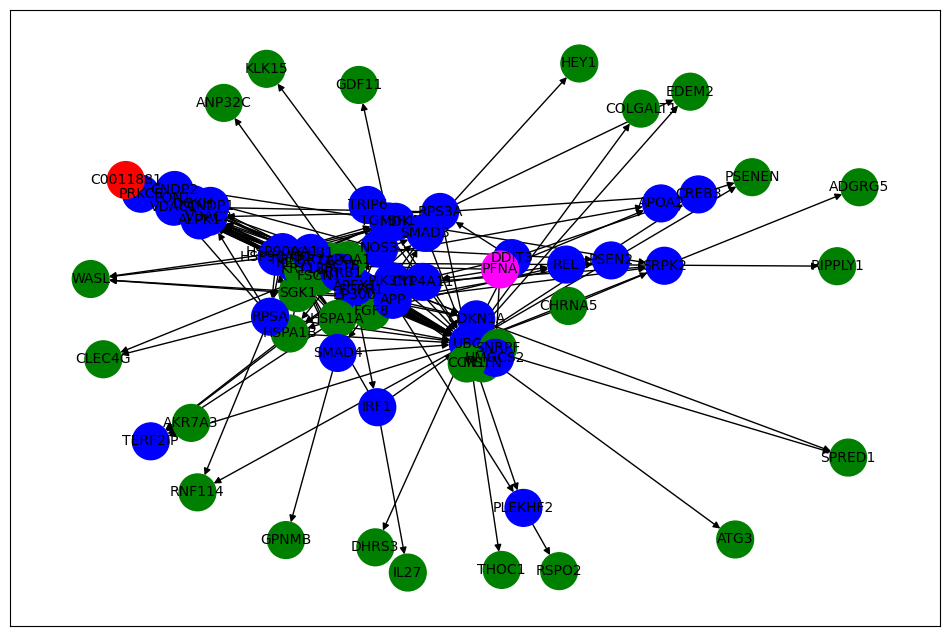

In [31]:
# Color mapping
color_map = {
    'PFAS': 'magenta',
    'Disease': 'red',
    'mediating-protein': 'green',
    'non-identified protein': 'blue'
}

# Compute node colors based on 'type' attribute
node_colors = [color_map[G.nodes[node]['type']] for node in G]

# Draw the graph
plt.figure(figsize=(12, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Layout for the nodes
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=700, edge_color='k', linewidths=1, font_size=10, arrows=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relationship'))

plt.show()

In [32]:
#   the path where you want to save your file
file_path = 'PFAS_prot_dkd_expanded_020524.graphml'

# Write the graph to a GraphML file
nx.write_graphml(G, file_path)

print(f"Network saved to {file_path}")

Network saved to PFAS_prot_dkd_expanded_020524.graphml


In [12]:
import os
# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory + '/graphml_output')


/Users/jagoodri/Library/CloudStorage/OneDrive-UniversityofSouthernCalifornia/Goodrich Projects Active/1_proj_dir/0_TODAY/1_code/jg_wd/ComptoxAI/graphml_output
